# tmp — may24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

model_type = 'poisson'

In [3]:
tr, meta = load_model(
    'poisson_uniform_c(-2)_rmax(1)_MNIST_z-10_k-32_<conv+b|conv+b>',
    'klconst0.001_gradx3-scale0.05_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_06,15:38)',
    device=device,
)

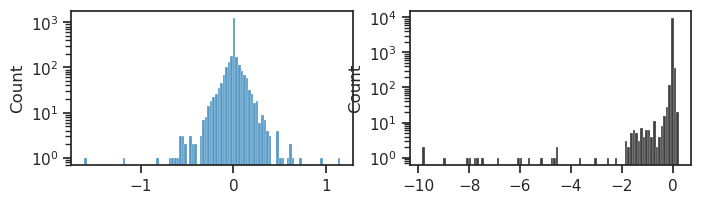

In [6]:
w_enc = tonp(tr.model.fc_enc.weight)
w_dec = tonp(tr.model.fc_dec.weight)

fig, axes = create_figure(1, 2, (8, 2))
sns.histplot(w_enc.ravel(), ax=axes[0], bins=100)
sns.histplot(w_dec.ravel(), ax=axes[1], bins=100, color='k')
axes[0].set(yscale='log')
axes[1].set(yscale='log')
plt.show()

In [3]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
cfg_vae['init_dist'] = 'StudentT'
cfg_vae['init_scale'] = 0.1

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_ch': 32, 'n_latents': 10, 'prior_clamp': -2.0, 'prior_log_dist': 'uniform', 'rmax_q': 1.0, 
'fit_prior': True, 'enc_type': 'conv', 'dec_type': 'conv', 'enc_bias': True, 'dec_bias': True, 'init_dist': 
'StudentT', 'init_scale': 0.1}

Trainer:
{'lr': 0.002, 'epochs': 1200, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 
'grad_clip': 1000}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  6.2 Mil   |
|     ---     |    ---     |
|     stem    |    352     |
|     enc     |  4.9 Mil   |
|    fc_enc   |   2.6 K    |
|    fc_dec   |   11.3 K   |
|     dec     |  1.2 Mil   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>
mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_07,05:46)

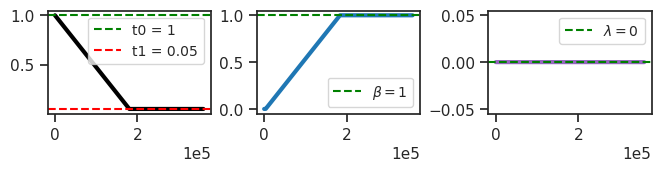

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

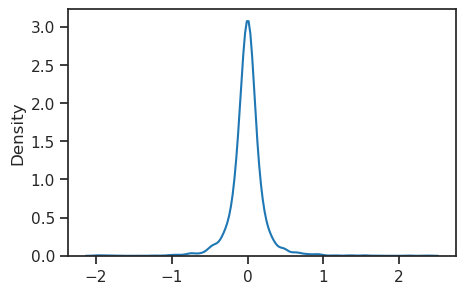

In [5]:
sns.kdeplot(tonp(vae.fc_enc.weight.data.ravel()));

In [ ]:
comment = f"klconst{tr.cfg.kl_const_portion}_gradx3-{vae.cfg.init_dist}Scale{vae.cfg.init_scale}_{tr.cfg.name()}"
# comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 960, avg loss: 34.986939:  80%|███████████████████▏    | 959/1200 [2:49:25<41:36, 10.36s/it]

In [ ]:
tr.show_recon(0.0), tr.show_samples(0.0);

In [ ]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

In [ ]:
df, df_summary = knn_analysis(
    x=etc['log_dr'],
    y=tonp(tr.dl_vld.dataset.tensors[1]),
    n_iter=100,
    verbose=True,
)

In [ ]:
df_summary